## Linear Regression Modeling

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Load Combined Game Data

In [3]:
games = pd.read_csv('../data/other_data/combined_data.csv')

print(games.shape)
games.head()

(1453, 38)


,game_key,event,year,name,id,category,start_time,duration,runners,host,...,chats_per_hour,is_Sony,is_Nintendo,is_Microsoft,is_Sega,is_Atari,is_PC,is_Mobile,is_Arcade,is_Other
0,SGDQ_2017_NieR: Automata,SGDQ,2017,NieR: Automata,34,NaN,2017-07-02 16:58:00,1.718056,Halfcoordinated,NaN,...,27990.363783,1,0,0,0,0,0,0,0,0
1,SGDQ_2017_Halo: Combat Evolved,SGDQ,2017,Halo: Combat Evolved,35,NaN,2017-07-02 19:08:00,1.414167,Garish,NaN,...,25464.466706,0,0,1,0,0,0,0,0,0
2,SGDQ_2017_Azure Striker Gunvolt 2,SGDQ,2017,Azure Striker Gunvolt 2,36,NaN,2017-07-02 20:54:00,0.880000,johncarls,NaN,...,18667.045455,0,1,0,0,0,0,0,0,0
3,SGDQ_2017_Battle Kid,SGDQ,2017,Battle Kid,72,NaN,2017-07-02 22:09:00,0.833333,InfestedRiche,NaN,...,19194.000000,0,1,0,0,0,0,0,0,0
4,SGDQ_2017_Battle Kid: Fortress of Peril,SGDQ,2017,Battle Kid: Fortress of Peril,1,NaN,2017-07-02 22:19:00,0.696111,InfestedRiche,NaN,...,19959.457302,0,1,0,0,0,0,0,0,0


### Create Feature Matrix and Target Variable

In [7]:
games.columns

Index(['game_key', 'event', 'year', 'name', 'id', 'category', 'start_time',
       'duration', 'runners', 'host', 'max_viewers', 'median_donation',
       'total_donations', 'donations_per_min', 'num_chats', 'is_Bonus',
       'is_TASBot', 'has_Incentive', 'has_Goal', 'developer', 'publisher',
       'initial_release_year', 'initial_consoles', 'initial_consoles_clean',
       'initial_generation', 'metascore', 'user_score', 'was_on_PC',
       'chats_per_hour', 'is_Sony', 'is_Nintendo', 'is_Microsoft', 'is_Sega',
       'is_Atari', 'is_PC', 'is_Mobile', 'is_Arcade', 'is_Other'],
      dtype='object')

In [9]:
# grouping feature columns by type for imputing/encoding later
# unused columns: game_key, name, id, category, runners, host, developer, initial_consoles, initial_consoles_clean, publisher, was_on_PC, start_time
nominal_columns = ['event',
                   'is_Bonus',
                   'is_TASBot',
                   'has_Incentive',
                   'has_Goal',
                   # 'publisher',
                   'initial_generation',
                   # 'was_on_PC',
                   'is_Sony',
                   'is_Nintendo',
                   'is_Microsoft',
                   'is_Sega',
                   'is_Atari',
                   'is_PC',
                   'is_Mobile',
                   'is_Arcade',
                   'is_Other'
                  ]

ordinal_columns = ['year',
                   # 'start_time',
                   'initial_release_year']

numerical_columns = ['duration',
                     'max_viewers',
                     'median_donation',
                     'total_donations',
                     'num_chats',
                     'metascore',
                     'user_score',
                     'chats_per_hour'
                    ]

In [11]:
# create feature matrix
X = games[nominal_columns + ordinal_columns + numerical_columns]

print(X.shape)

# create log target variable
# games['donations_per_min_log'] = np.log(games['donations_per_min'] + 1)
# y = games['donations_per_min_log']

# create sqrt target variable
games['donations_per_min_sqrt'] = np.sqrt(games['donations_per_min'])
y = games['donations_per_min_sqrt']

# create target variable
# y = games['donations_per_min']

print(y.shape)

(1453, 25)
(1453,)


### Create Column Transformers

In [14]:
# create transformer for nominal data columns
nominal_pipeline = Pipeline([
    ('si', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))
])

In [16]:
# create transformer for ordinal data columns
ordinal_pipeline = Pipeline([
    ('si', SimpleImputer(strategy = 'most_frequent')),
    ('ord', OrdinalEncoder())
])

In [18]:
# create transformer for numerical data columns
numerical_pipeline = Pipeline([
    ('si', SimpleImputer(strategy = 'mean')),
    ('ss', StandardScaler())
])

In [20]:
# combine nominal, ordinal, numerical pipelines in same column transformer
basic_preprocessor = ColumnTransformer([
    ('nominal_preprocessor', nominal_pipeline, nominal_columns),
    ('ordinal_preprocessor', ordinal_pipeline, ordinal_columns),
    ('numerical_preprocessor', numerical_pipeline, numerical_columns),
])

### Train-Test Split

In [23]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42,
                                                   test_size = 0.25
                                                   )

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (1089, 25)
Shape of X_test: (364, 25)
Shape of y_train: (1089,)
Shape of y_test: (364,)


### Create Linear Regression Pipeline

In [26]:
# create linear regression pipeline
lr_pipe = Pipeline([
    ('preprocessor', basic_preprocessor),
    ('estimator', LinearRegression())
])

In [28]:
# fit pipeline to training data
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['event', 'is_Bonus',
                                                   'is_TASBot', 'has_Incentive',
                                                   'has_Goal',
                                                   'initial_generation',
                                                   'is_Sony', 'is_Nintendo',
                                                   'is_Microsoft', 'is_Sega',
                                                   'is_Atar...
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['year',
                                                   'initial_release_year']),
                                                 ('numerical_preprocessor',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['duration', 'max_viewers',
                                                   'median_donation',
                                                   'total_donations',
                                                   'num_chats', 'metascore',
                                                   'user_score',
                                                   'chats_per_hour'])])),
                ('estimator', LinearRegression())])

### Evaluate Linear Regression Model

In [33]:
# check model scores
train_score = lr_pipe.score(X_train, y_train)
test_score = lr_pipe.score(X_test, y_test)
print(f'Training r2 score: {round(train_score,3)}')
print(f'Testing r2 score: {round(test_score,3)}')

Training r2 score: 0.61
Testing r2 score: 0.589


In [35]:
# calculate baseline donations per minute
y_baseline = y.mean()

# create np array full of baseline data to use for baseline prediction score
y_baselines = np.full(y_test.shape[0], y_baseline)

In [37]:
# calculate model predictions
y_preds = lr_pipe.predict(X_test)

In [39]:
# r2 score for baseline
print(f'Baseline r2 score: {r2_score(y_test, y_baselines)}')
print(f'Model r2 score: {r2_score(y_test, y_preds)}')

Baseline r2 score: -0.0008977596877890459
Model r2 score: 0.5894194050088312


In [41]:
# check intercept and coefficients
model_intercept = lr_pipe.named_steps['estimator'].intercept_
model_coefs = lr_pipe.named_steps['estimator'].coef_

print(model_intercept)
print(model_coefs)

5.060431897454663
[ 8.20608650e-01  5.24058966e-02  1.16097136e+01  6.25135506e-02
  6.44345520e-01  5.95645774e-01  4.26687711e-01  9.65163246e-01
 -4.59715796e-01  1.07638315e-02  1.54894753e+00  2.41096479e+00
  1.83854189e+00  3.05249200e-01  1.44009638e-01  8.67416125e-01
 -1.15577089e+00 -7.07846045e-02 -1.82017990e+00 -2.70115454e+00
 -1.48488952e+00 -1.97827687e-01  1.75594985e+00  2.76399500e-02
 -9.87839239e-01  3.26460483e+00  1.16188316e+00  3.82381981e+00
 -3.39655363e-01  3.80925985e-01  1.41567182e-01  1.07605001e+00]


In [43]:
nominal_features = lr_pipe.named_steps['preprocessor'].named_transformers_['nominal_preprocessor'].get_feature_names_out(nominal_columns)

print(nominal_features.shape)
nominal_features

(22,)


array(['event_SGDQ', 'is_Bonus_1.0', 'is_TASBot_1.0', 'has_Incentive_1.0',
       'has_Goal_1.0', 'initial_generation_3', 'initial_generation_4',
       'initial_generation_5', 'initial_generation_6',
       'initial_generation_7', 'initial_generation_8',
       'initial_generation_9', 'initial_generation_Various', 'is_Sony_1',
       'is_Nintendo_1', 'is_Microsoft_1', 'is_Sega_1', 'is_Atari_1',
       'is_PC_1', 'is_Mobile_1', 'is_Arcade_1', 'is_Other_1'],
      dtype=object)

In [66]:
feature_names = list(nominal_features) + list(ordinal_columns) + list(numerical_columns)

coefs_df = pd.DataFrame(data = {'feature' : feature_names,
                                'coef': model_coefs}).sort_values(by = 'coef', ascending = False)

# dropping select feature from coefficients
# dropping total_donations, max_viewers, year, initial_release_year,
coefs_df.drop(index = [27,25,22,23,28], inplace = True)

coefs_df

,feature,coef
2,is_TASBot_1.0,11.609714
11,initial_generation_9,2.410965
12,initial_generation_Various,1.838542
10,initial_generation_8,1.548948
26,median_donation,1.161883
31,chats_per_hour,1.076050
7,initial_generation_5,0.965163
15,is_Microsoft_1,0.867416
0,event_SGDQ,0.820609
4,has_Goal_1.0,0.644346


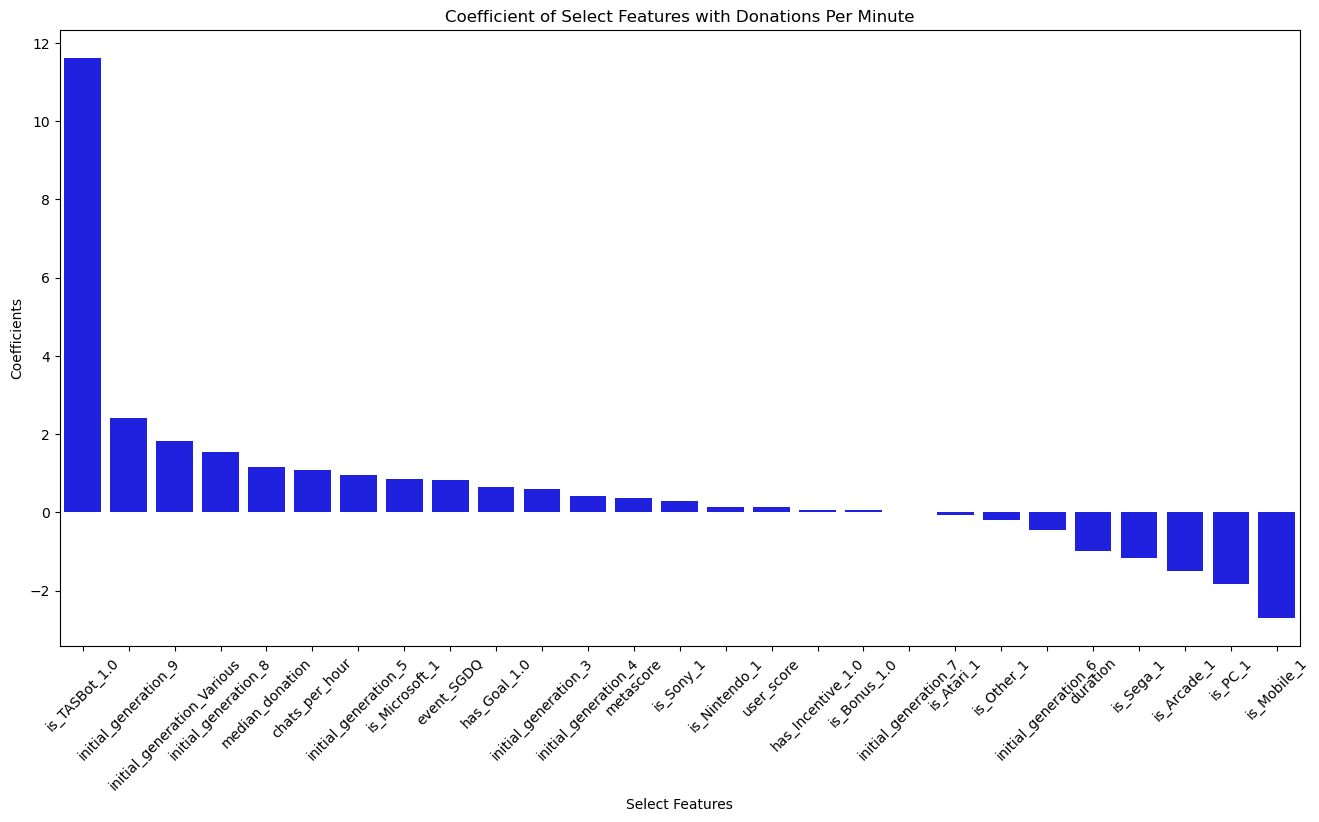

In [49]:
# graph correlations
plt.figure(figsize = (16, 8))
sns.barplot(x = coefs_df['feature'],
            y = coefs_df['coef'],
            color = 'blue')
plt.title('Coefficient of Select Features with Donations Per Minute')
plt.xlabel('Select Features')
plt.xticks(rotation = 45)
plt.ylabel('Coefficients')
plt.savefig('../graphics/dpm_select_lin_reg_coefficients.jpeg')
plt.show()